# Segmentación de Imágenes Sentinel-2 para Deep Learning

## Used:

*   https://stackoverflow.com/questions/42233297/reshape-array-in-numpy
*   https://stackoverflow.com/questions/34097281/convert-a-tensor-to-numpy-array-in-tensorflow
*   https://github.com/microsoft/torchgeo/discussions/592

In [9]:
%pip install -q torchgeo
%pip install -q matplotlib==3.1.1
%pip install -q beautifulsoup4
%pip install -q lxml

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchgeo 0.3.1 requires matplotlib<4,>=3.3, but you have matplotlib 3.1.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [185]:
import os
import tempfile
import torch
import matplotlib.pyplot as plt
import cv2
from bs4 import BeautifulSoup 

from torchgeo.datasets import RasterDataset, unbind_samples
from torchgeo.datasets import Sentinel2, stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
from torch.utils.data import DataLoader
from PIL import Image

from torchvision.utils import save_image

from pathlib import Path
import numpy as np

from bs4 import BeautifulSoup

import glob

## DIR manipulation

In [186]:
ROOT_DIR = "/home/manuel/Descargas/"

Available maps in $ROOT_DIR

In [187]:
os.listdir(ROOT_DIR)

['Tutorial Rápido LaTeX overleaf, formato de escuela EIE.pdf',
 's41598-021-99998-z.pdf',
 'dd7aca31-3503-4097-879c-db5fe0eb2c0c_70547.pdf',
 'bp_numba.py',
 'certificado.pdf',
 'Formulario_N_2.docx',
 'INFORMES-20221018T114952Z-001',
 'Módulo 2_ Arte IA-1.pdf',
 'MicroSoft Office 2007 With Key -THADOGG',
 'WhatsApp Image 2022-09-05 at 19.17.16.jpeg',
 'boletaFuenteCompra.pdf',
 'double-driver-4.1.0',
 'sensors-20-06936-v3.pdf',
 'Acercando_la_IA_a_colegios_de_ensenanza_media_VinculacionEIE-1.pdf',
 'ar32e301.exe',
 'rtf-fungi_sib_aysen-v1.6.rtf',
 'EJEMPLO 3.ipynb',
 'CuentaRut_CartolaHistorica_16-08-2022_00.42.10.xls',
 'tv-training-code.py',
 '2017_MritunjayRaiSCIpaper.pdf',
 'segundoEtiquetado',
 'PLANIFICACION MAGISTER v2.0-1.pdf',
 'BetaPUCV_ExperienciaDetectorCliqui.ipynb',
 'CuentaRut_CartolaHistorica_15-08-2022_23.59.33.xls',
 '.~lock.Modulo 2 Final.pptx#',
 'metadata.csv',
 'arduino-ide_2.0.1_Linux_64bit.AppImage',
 'c.coco-segmentation_aug.zip',
 'Arte AI.zip',
 'Intruccion

In [188]:
# modify to select desired folder
ANALYZED_MAP = "gaby2_2019"

In [189]:
aa = os.path.relpath(ROOT_DIR + ANALYZED_MAP)
u = os.listdir(aa)[0]
print("full path:", u)
date = u.split("_")[2].split("T")[0]
print("date of file:",date)

full path: S2B_MSIL2A_20191230T143719_N0213_R096_T19KEQ_20191230T184313.SAFE
date of file: 20191230


In [190]:
#arreglar esto
a1 = os.path.join(aa,u)
print("a1:",a1)

a2 = a1 + "/GRANULE"

print("a2:",a2)

a3 = os.path.join(a2,
             os.listdir(a2)[0])
#a1 tiene el folder XML
print("a3:", a3)


a4 = a3 + '/IMG_DATA/R10m'
os.listdir(a4)

a1: ../Descargas/gaby2_2019/S2B_MSIL2A_20191230T143719_N0213_R096_T19KEQ_20191230T184313.SAFE
a2: ../Descargas/gaby2_2019/S2B_MSIL2A_20191230T143719_N0213_R096_T19KEQ_20191230T184313.SAFE/GRANULE
a3: ../Descargas/gaby2_2019/S2B_MSIL2A_20191230T143719_N0213_R096_T19KEQ_20191230T184313.SAFE/GRANULE/L2A_T19KEQ_A014708_20191230T144612


['T19KEQ_20191230T143719_TCI_10m.jp2',
 'T19KEQ_20191230T143719_B08_10m.jp2',
 'T19KEQ_20191230T143719_AOT_10m.jp2',
 'T19KEQ_20191230T143719_B03_10m.jp2',
 'T19KEQ_20191230T143719_WVP_10m.jp2',
 'T19KEQ_20191230T143719_B02_10m.jp2',
 'T19KEQ_20191230T143719_B04_10m.jp2']

In [191]:
directory = 'exported_'+ ANALYZED_MAP

if not os.path.exists(directory):
    os.makedirs(directory)

Get metadata

## Manipulating Metadata

In [192]:
for XML_FILE in Path(a1).glob("MTD_*.xml"):
  print(XML_FILE)

../Descargas/gaby2_2019/S2B_MSIL2A_20191230T143719_N0213_R096_T19KEQ_20191230T184313.SAFE/MTD_MSIL2A.xml


In [193]:
# Reading the data inside the xml file to a variable under the name  data
with open(XML_FILE, 'r') as f:
    data = f.read() 

# Passing the stored data inside the beautifulsoup parser 
bs_data = BeautifulSoup(data, 'xml') 

table = bs_data.find_all('EXT_POS_LIST') 
print(table) 

[<EXT_POS_LIST>-22.606495447961677 -69.00018 -22.602942404652758 -67.931915 -23.59462791886889 -67.92404 -23.598354935643496 -69.00018 -22.606495447961677 -69.00018 </EXT_POS_LIST>]


In [194]:
paragraphs = []
for x in table:
    paragraphs.append(str(x))

paragraphs[0] # its a list

'<EXT_POS_LIST>-22.606495447961677 -69.00018 -22.602942404652758 -67.931915 -23.59462791886889 -67.92404 -23.598354935643496 -69.00018 -22.606495447961677 -69.00018 </EXT_POS_LIST>'

In [195]:
replace_dic = {'<EXT_POS_LIST>': '', ' </EXT_POS_LIST>': ''} # to trim the string and get a clean output

In [196]:
def replace_all(text, replace_dic):
    for i, j in replace_dic.items():
        text = text.replace(i, j)
    return text

In [197]:
coordinates = replace_all(paragraphs[0], replace_dic)

In [198]:
print(coordinates)

-22.606495447961677 -69.00018 -22.602942404652758 -67.931915 -23.59462791886889 -67.92404 -23.598354935643496 -69.00018 -22.606495447961677 -69.00018


In [199]:
sepa = coordinates.split(" ")

In [200]:
print(sepa)

['-22.606495447961677', '-69.00018', '-22.602942404652758', '-67.931915', '-23.59462791886889', '-67.92404', '-23.598354935643496', '-69.00018', '-22.606495447961677', '-69.00018']


In [201]:
def pairSeparator(t):
    it = iter(t)
    return zip(it,it)

In [202]:
zipSeparated = pairSeparator(sepa)

In [203]:
values = list(zipSeparated)
print(values)

[('-22.606495447961677', '-69.00018'), ('-22.602942404652758', '-67.931915'), ('-23.59462791886889', '-67.92404'), ('-23.598354935643496', '-69.00018'), ('-22.606495447961677', '-69.00018')]


In [204]:
#export coordinates of image to txt in folder
with open(directory + '/coordinates_'+ANALYZED_MAP+'.txt', 'w') as output:
    for row in values:
        output.write(str(row) + '\n')

##Get Dataset

In [205]:
otrosentinel = a4

In [206]:
#dataset = Sentinel2(root=otrosentinel, bands=['B02', 'B03' , 'B04', 'B08'])
dataset = Sentinel2(root=otrosentinel, res=10, bands=["B04", "B03", "B02"])

In [207]:
root = otrosentinel

List files in directory

In [208]:
sorted(os.listdir(root))

['T19KEQ_20191230T143719_AOT_10m.jp2',
 'T19KEQ_20191230T143719_B02_10m.jp2',
 'T19KEQ_20191230T143719_B03_10m.jp2',
 'T19KEQ_20191230T143719_B04_10m.jp2',
 'T19KEQ_20191230T143719_B08_10m.jp2',
 'T19KEQ_20191230T143719_TCI_10m.jp2',
 'T19KEQ_20191230T143719_WVP_10m.jp2']

In [209]:
class Sentinels2(RasterDataset):
    filename_glob = "T*_B02_10m.jp2"
    filename_regex = r"^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]

In [210]:
dataset = Sentinels2(root)
print(dataset)

Sentinels2 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=499980.0, maxx=609780.0, miny=7390240.0, maxy=7500040.0, mint=1577727439.0, maxt=1577727439.999999)
    size: 1


In [211]:
class Sentinele2(RasterDataset):
    filename_glob = "T*_B02_10m.jp2"
    filename_regex = r"^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 6000, min=0, max=1)

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [212]:
size = 4096

In [213]:
ds = dataset

## To plot random images do:

In [214]:
from torchgeo.samplers import Units

length of sample is:  3


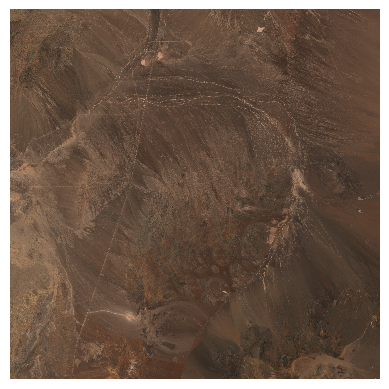

In [215]:
torch.manual_seed(1) # set random seed

dataset = Sentinele2(root) # define Sentinel
sampler = RandomGeoSampler(dataset=dataset, size=size, length=1)
dataloader = DataLoader(dataset=dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
  sample = unbind_samples(batch)[0]
  print("length of sample is: ",len(sample))
  dataset.plot(sample)
  sample
  plt.axis("off")
  plt.show()


##Now we can get the coordinates from the rasterized map
## keep format 
"minx, maxx, miny, maxy"

In [216]:
batch.keys()

dict_keys(['image', 'crs', 'bbox'])

In [217]:
alaa = batch['crs']
print(alaa)

[CRS.from_epsg(32719)]


In [218]:
upa = alaa[0]

In [219]:
#upa.to_string()

In [220]:
print(upa)

EPSG:32719


In [221]:
type(upa)

rasterio.crs.CRS

In [222]:
bebebe = batch['bbox'][0]
print(bebebe)

BoundingBox(minx=501995.7423567772, maxx=542955.7423567772, miny=7445302.26806879, maxy=7486262.26806879, mint=1577727439.0, maxt=1577727439.999999)


In [223]:
print(bebebe.__getitem__(0))
print(bebebe.__getitem__(1))
print(bebebe.__getitem__(2))
print(bebebe.__getitem__(3))

501995.7423567772
542955.7423567772
7445302.26806879
7486262.26806879


In [224]:
from pyproj import Proj, Transformer

def formatFilenametFromCoordiates(batch,to_epsg="epsg:4326"):
  """
  Use this function to rename each rasterized img to a coordinate-based name
  ex: minx_maxx_miny_maxy.png

  uses Pyproj to format to epsg:4326
  """
  crs = batch['crs']
  from_epsg = str(crs[0])

  # Formats the transformer to corresponding EPSG config
  transformer = Transformer.from_crs(from_epsg, to_epsg)

  # gets bboxes from img
  bboxes = batch['bbox'][0]

  minx, miny = transformer.transform(bboxes.__getitem__(0), bboxes.__getitem__(2))
  maxx, maxy = transformer.transform(bboxes.__getitem__(1), bboxes.__getitem__(3))

  filename =  str(minx)+'_'+str(maxx)+'_'+str(miny)+'_'+str(maxy)

  return filename

In [225]:
def saveImageToFolder(filename, formatedImage):
    formatedImage.save(directory +"/"+filename+".png",format='PNG')

In [226]:
dasdasdas = formatFilenametFromCoordiates(batch)
print(dasdasdas)

-23.100973739820503_-22.730413653731205_-68.9805113072165_-68.58167280259552


## To plot grid images (with overlaping) do:

In [227]:
size = 256

In [228]:
gridSampler = GridGeoSampler(dataset=dataset, size=size, stride=size*0.8) # stride: distance to skip 
dl = DataLoader(ds, sampler=gridSampler, collate_fn=stack_samples)

In [229]:
def formatToSave(sample):
  sampleScaled = (sample[[3,2,1],:,:] / 6000).clip(0., 1.) # re-scaling and defining min value as 0 and max value as 1
  sampleNumpy = sampleScaled.numpy()
  sampleMult = (sampleNumpy * 255).astype(np.uint8)
  trasposedImg = np.transpose( sampleMult, (1, 2, 0))
  formatedImage = Image.fromarray((trasposedImg).astype(np.uint8))

  return formatedImage

In [230]:
def imageSaver(formatedImage, index):
  formatedImage.save(directory +"/"+ANALYZED_MAP +"_%d.png" % index, format='PNG')

In [231]:
index = 0
for batch in dl:
    filename = formatFilenametFromCoordiates(batch)
    sample = unbind_samples(batch)[0]
    formatedImage = formatToSave(sample['image'])
    saveImageToFolder(filename,formatedImage)
    #imageSaver(formatedImage, index)
    #dataset.plot(sample)
    #plt.axis("off")
    #plt.show()
    index = index+1